Dependency check and load huggingface scripts

In [1]:
!cd /content/
!git clone https://github.com/huggingface/diffusers.git
!pip install ./diffusers
!pip install -U -r /content/diffusers/examples/text_to_image/requirements.txt

Cloning into 'diffusers'...
remote: Enumerating objects: 47910, done.
remote: Counting objects: 100% (1538/1538), done.
remote: Compressing objects: 100% (658/658), done.
remote: Total 47910 (delta 1040), reused 1174 (delta 779), pack-reused 46372
Receiving objects: 100% (47910/47910), 31.80 MiB | 16.03 MiB/s, done.
Resolving deltas: 100% (35350/35350), done.
Processing ./diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.25.0.dev0-py3-none-any.whl size=1816330 sha256=97a498147c7c49dc78fcf3d6c2c846046e9ff9f6bb336e06df14d6e9ce59e940
  Stored in directory: /tmp/pip-ephem-wheel-cache-o8j758f4/wheels/95/c5/3b/e1b4269f8a2584de57e75f949a185b48fc4144e9a91fc9965a
Successfully built diffusers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 114.5 MB/s eta 0:00:00

Check GPU avalibility

In [2]:
!nvidia-smi

Mon Dec 11 02:58:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Setup accelerate config for lora model

> In regular text-to-image model, "--mixed_precision" can be added to accelerate traning speed as well as lower the memory use. E.g. !accelerate config default --mixed_precision fp16

In [ ]:
!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


Login huggingface accont and setup base model, dataset and output path.

In [5]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import os

os.environ['MODEL_NAME'] = f'runwayml/stable-diffusion-v1-5'
os.environ['DATASET_NAME'] = f'jwl25b/final_project_dataset'
os.environ['OUTPUT_DIR'] = f'testModelSDv1-2'

Training model. In this case, we are training lora adapter.




> Be sure to run it in colab pro with high RAM, otherwise would be error due to insufficient memory.


Config of train_batch_size, num_train_epochs might various depend on different hardware:



1. T4 with 15GB GPU RAM
2. V100 with 16GB GPU RAM
3. A100 with 40GB GPU RAM







In [ ]:
!accelerate launch diffusers/examples/text_to_image/train_text_to_image_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --dataset_name=$DATASET_NAME \
  --resolution=512 --center_crop --random_flip \
  --gradient_accumulation_steps=4 \
  --gradient_checkpointing \
  --train_batch_size=2 \
  --num_train_epochs=300 --checkpointing_steps=10000 \
  --learning_rate=1e-04 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --validation_prompt="Tommy Hilfiger men's fashion product"\
  --validation_epochs=30 \
  --seed=42 \
  --push_to_hub \
  --output_dir=$OUTPUT_DIR

# For regular text-to-image model, use:
#!accelerate launch diffusers/examples/text_to_image/train_text_to_image.py \
#  --pretrained_model_name_or_path=$MODEL_NAME \
#  --dataset_name=$DATASET_NAME \
#  --use_ema \
#  --resolution=512 --center_crop --random_flip \
#  --train_batch_size=1 \
#  --gradient_accumulation_steps=4 \
#  --gradient_checkpointing \
#  --mixed_precision="fp16" \
#  --max_train_steps=400 \
#  --learning_rate=1e-05 \
#  --max_grad_norm=1 \
#  --push_to_hub \
#  --checkpointing_steps=100000 \
#  --lr_scheduler="constant" \
#  --lr_warmup_steps=0 \
#  --output_dir=$OUTPUT_DIR

Download and setup base model and lora adapter for check

In [6]:
# Stable Diffusion V1
from diffusers import StableDiffusionPipeline
import torch
from PIL import Image

lora_path = "jwl25b/testModelSDv1-2"
model_path = 'runwayml/stable-diffusion-v1-5'
pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16)
pipe.unet.load_attn_procs(lora_path)

#Turn off safety checker
#pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images))

pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


pytorch_lora_weights.safetensors:   0%|          | 0.00/3.23M [00:00<?, ?B/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.25.0.dev0",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

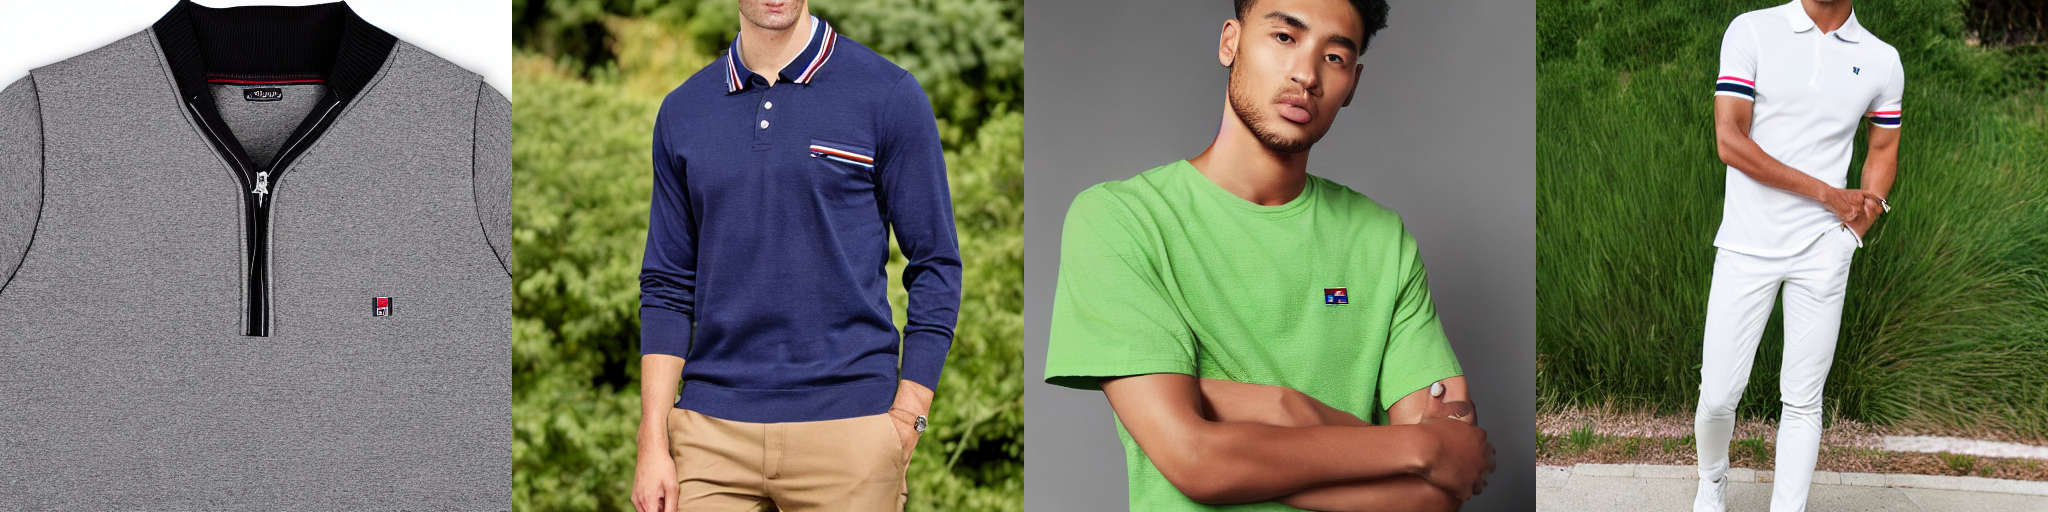

In [7]:

# Run inference using prompts to acquire 4 image panels
image1 = pipe(prompt="Quarter-Zip V-Neck Black Sweatshirt with Tommy Logo at the chest").images[0]
image1.save("productImage1.png")

image2 = pipe(prompt="Solid Crewneck Navy Blue Crewneck polo with signature stripe tipping").images[0]
image2.save("productImage2.png")

image3 = pipe(prompt="Embroidered Tommy Logo Green T-Shirt with textured boxy knit").images[0]
image3.save("productImage3.png")

image4 = pipe(prompt="Slim Fit Stripe Classic White Polo with Tommy Flag Logo").images[0]
image4.save("productImage4.png")

# Image grid helper function from HuggingFace
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

all_images = [image1, image2, image3, image4]
grid = image_grid(all_images, rows=1, cols=4)
grid